In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re


from sklearn.model_selection import train_test_split

# K Means Clustering
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# DT 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV 


In [2]:
os.listdir()


['Movie_Rankings.csv',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Ranked.csv',
 'Movies_Updated.ipynb',
 '.ipynb_checkpoints',
 'Movies - Personal Inquiry.ipynb',
 'Movies.csv',
 'MLR_Movies.ipynb']

In [3]:
data = pd.read_excel('Movies_2020.xlsx', 
                    dtype = {'ReleaseYear': int}
                    )

In [4]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama


In [5]:
print("There are ",data.shape[0], " movies in this dataset")

There are  157  movies in this dataset


In [6]:
data.dtypes

Name                   object
Rating                float64
WatchDate      datetime64[ns]
ReleaseYear             int64
Director               object
Genre                  object
dtype: object

In [7]:
data.isna().sum()

Name           0
Rating         0
WatchDate      0
ReleaseYear    0
Director       0
Genre          0
dtype: int64

#### The movie watchings are skewed heavily toward recent movies, with some noticable peaks in 1950s (due to Hitchcock & Audrey Hepburn films)

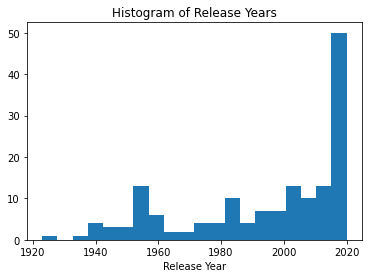

In [8]:
plt.hist(data['ReleaseYear'], bins = 20)
plt.xlabel('Release Year')
plt.title("Histogram of Release Years")
plt.show()

#### The Ratings also show that I generally rate movies highly, this distribution is right-skewed as well

In [9]:
data['Rating'].describe()

count    157.000000
mean       0.795987
std        0.132112
min        0.300000
25%        0.720000
50%        0.850000
75%        0.900000
max        0.990000
Name: Rating, dtype: float64

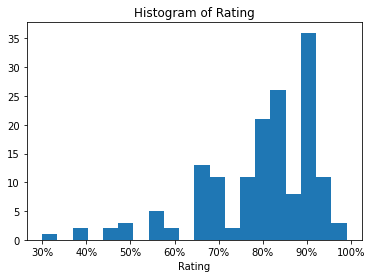

In [10]:
plt.hist(data['Rating'], bins = 20)
plt.xlabel('Rating')
plt.title("Histogram of Rating")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

#### My movie intake is quite high during the 2020 Global Covid-19 Pandemic. It also was pretty high in early 2016, as I was in my senior spring of college. This charts the quarterly sum of movies. 

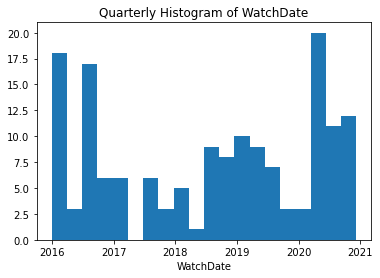

In [11]:
plt.hist(data['WatchDate'], bins = 20)
plt.xlabel('WatchDate')
plt.title("Quarterly Histogram of WatchDate")
plt.show()

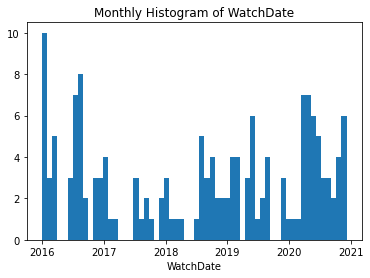

In [12]:
plt.hist(data['WatchDate'], bins = 60)
plt.xlabel('WatchDate')
plt.title("Monthly Histogram of WatchDate")
plt.show()

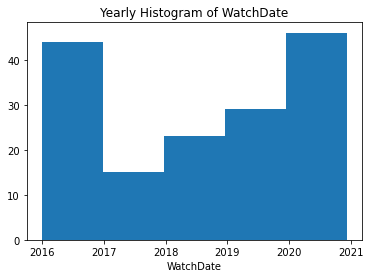

In [13]:
plt.hist(data['WatchDate'], bins = 5)
plt.xlabel('WatchDate')
plt.title("Yearly Histogram of WatchDate")
plt.show()

#### What is my average rating over time?

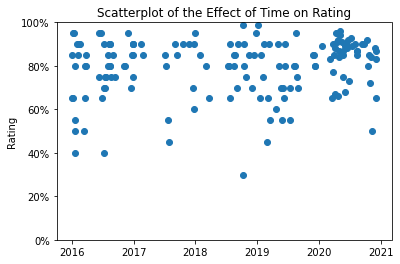

In [14]:
plt.scatter(data['WatchDate'], data['Rating'])
plt.title("Scatterplot of the Effect of Time on Rating")
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### Am I watching newer movies over time?

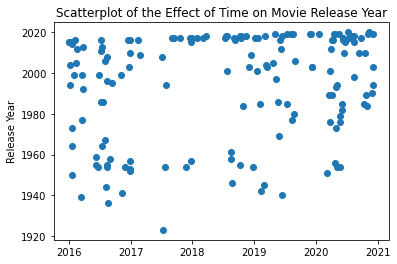

In [15]:
plt.scatter(data['WatchDate'], data['ReleaseYear'])
plt.title("Scatterplot of the Effect of Time on Movie Release Year")
plt.ylabel('Release Year')
plt.show()

#### Create a Monthly Aggregation to Summarize Trends

In [16]:

data['WatchMonth'] = data['WatchDate'].values.astype('datetime64[M]')

data_month = data.groupby(['WatchMonth']).agg(
                    count = pd.NamedAgg( column = 'Name', aggfunc = 'count'),
                    rating = pd.NamedAgg( column = 'Rating', aggfunc = 'mean'),
                    movieyear = pd.NamedAgg( column = 'ReleaseYear', aggfunc = 'mean')
                )
data_month = data_month.reset_index()
#data_month.rename(columns = {'Name':'Count'}, inplace = True)
data_month.head()


,WatchMonth,count,rating,movieyear
0,2016-01-01,10,0.720000,1994.30
1,2016-02-01,3,0.883333,2011.00
2,2016-03-01,5,0.720000,1984.00
3,2016-06-01,4,0.825000,1966.75
4,2016-07-01,6,0.700000,1996.00


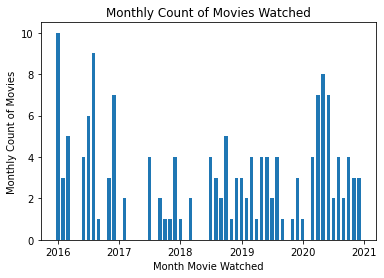

In [17]:
plt.bar(data_month['WatchMonth'], data_month['count'], width = 20)
plt.xlabel('Month Movie Watched')
plt.ylabel('Monthly Count of Movies')
plt.title('Monthly Count of Movies Watched')
plt.show()

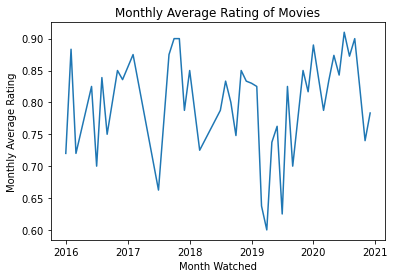

In [18]:
plt.plot(data_month['WatchMonth'], data_month['rating'])
plt.title('Monthly Average Rating of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Rating')
plt.show()

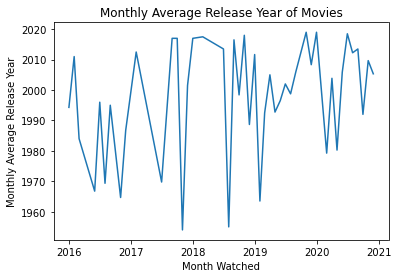

In [19]:
plt.plot(data_month['WatchMonth'], data_month['movieyear'])
plt.title('Monthly Average Release Year of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Release Year')
plt.show()

#### Is there a relationship between Year of the Movie Release and my Rating?

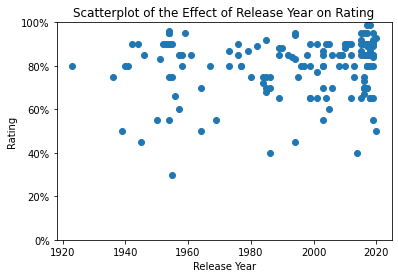

In [20]:
plt.scatter(data['ReleaseYear'], data['Rating'])
plt.title('Scatterplot of the Effect of Release Year on Rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### What are my highest rated movies?

In [21]:
data.sort_values(by=['Rating']).tail(5)

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth
120,Hidden figures,0.95,2020-04-10,2016,Theodore Melfi,Drama/History,2020-04-01
105,The Farewell,0.95,2019-08-17,2019,Lulu Wang,Drama/Comedy,2019-08-01
126,The rear window,0.96,2020-05-05,1954,Alfred Hitchcock,Noir/Mystery,2020-05-01
75,Colette,0.99,2018-10-12,2018,Wash Westmoreland,Historical/Drama,2018-10-01
83,On The Basis of Sex,0.99,2019-01-06,2017,Mimi Leder,Historical/Drama,2019-01-01


#### Which Director have I seen the most movies from?

In [22]:
data['Director'].value_counts().head()

Hitchcock            6
Robert Zemeckis      4
Michael Curtiz       4
Sylvester Stalone    3
Damien Chazelle      3
Name: Director, dtype: int64

### Label Encoding the Genre Column 

In [23]:
data[['Genre1','Genre2']] = data['Genre'].str.split('/',expand=True)

In [56]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


Due to the mispellings in the underlying dataset, do manual combinations to reduce the dimensionality of the dataset

In [57]:
#data['Genre1'].value_counts()

In [58]:
#data['Genre2'].value_counts()

In [59]:
#data['Genre_Romance'] = 0
#data.loc[ data['Genre'].str.contains('Romance'), 'Genre_Romance'] = 1


data['Romance_Ind'] = 0 
r = re.compile(r'.*(Romance).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Romance_Ind'] = 1
  
data['Comedy_Ind'] = 0 
r = re.compile(r'.*(Comedy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Comedy_Ind'] = 1
 
data['Drama_Ind'] = 0 
r = re.compile(r'.*(Drama).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Drama_Ind'] = 1

data['Thriller_Ind'] = 0 
r = re.compile(r'.*(Thriller).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Thriller_Ind'] = 1
 
data['Fantasy_Ind'] = 0 
r = re.compile(r'.*(Fantasy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Fantasy_Ind'] = 1

data['Crime_Ind'] = 0 
r = re.compile(r'.*(Crime).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Crime_Ind'] = 1

data['Sport_Ind'] = 0 
r = re.compile(r'.*(Sport).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Sport_Ind'] = 1

data['Historical_Ind'] = 0 
r = re.compile(r'.*(Historical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Historical_Ind'] = 1


data['Mystery_Ind'] = 0 
r = re.compile(r'.*(Mystery).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Mystery_Ind'] = 1


data['Action_Ind'] = 0 
r = re.compile(r'.*(Action).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Action_Ind'] = 1


data['Musical_Ind'] = 0 
r = re.compile(r'.*(Musical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Musical_Ind'] = 1


data['SciFi_Ind'] = 0 
r = re.compile(r'.*(Sci).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'SciFi_Ind'] = 1

data['Other_Ind'] = 0
data.loc[ (data['Romance_Ind'] == 0) & (data['Comedy_Ind'] == 0) & (data['Drama_Ind'] == 0) & \
          (data['Thriller_Ind'] == 0) & (data['Fantasy_Ind'] == 0) & (data['Crime_Ind'] == 0) & \
         (data['Sport_Ind'] == 0) & (data['Historical_Ind'] == 0) & (data['Mystery_Ind'] == 0) & \
         (data['Action_Ind'] == 0) & (data['Musical_Ind'] == 0 ) & (data['SciFi_Ind'] == 0)
         , 'Other_Ind'] = 1



In [60]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


In [61]:
data.describe()

,Rating,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.795987,1994.070064,0.242038,0.318471,0.560510,0.082803,0.070064,0.057325,0.050955,0.044586,0.108280,0.044586,0.070064,0.070064,0.025478
std,0.132112,25.775439,0.429688,0.467374,0.497913,0.276465,0.256071,0.233206,0.220610,0.207053,0.311728,0.207053,0.256071,0.256071,0.158075
min,0.300000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.720000,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.850000,2003.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,2016.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
data.iloc[:, 8:].sum()

Romance_Ind       38
Comedy_Ind        50
Drama_Ind         88
Thriller_Ind      13
Fantasy_Ind       11
Crime_Ind          9
Sport_Ind          8
Historical_Ind     7
Mystery_Ind       17
Action_Ind         7
Musical_Ind       11
SciFi_Ind         11
Other_Ind          4
dtype: int64

In [67]:
data.columns

Index(['Name', 'Rating', 'WatchDate', 'ReleaseYear', 'Director', 'Genre',
       'WatchMonth', 'Genre1', 'Genre2', 'Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind'],
      dtype='object')

In [63]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


#### Split the Data

In [72]:
X = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind']]
y = data.loc[:, ['Rating']]

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = .30, train_size = .70, random_state = 42)
    

In [73]:
X_Train.head()

,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
140,2017,0,0,1,0,0,0,1,0,0,0,0,0,0
11,2005,0,0,1,0,0,0,0,0,1,0,0,0,0
79,2018,0,0,1,0,0,0,0,1,0,0,0,0,0
68,2018,0,0,0,0,0,0,0,0,0,1,0,1,0
149,1989,0,0,0,0,0,0,0,0,0,0,0,1,0


#### We can't do Clustering on a Binary Dataset. We will have to get something else - such as 'Sentiment Score' using NLP Methods. 
#### Get Sentiment using NLTK, then use that as an input to Clustering 

### Decision Tree on Binary Genre + Release Year Data 

Basic Decision Tree Model

In [103]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.5435844370860925
Mean Squared Error: 0.01294895833333333


Grid Search for Best Parameters

In [104]:
def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['mse', 'mae','friedman_mse']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(10, 20, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeRegressor(random_state=42),
                       param_grid=param_grid, 
                       #scoring='neg_mean_squared_error',
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [105]:
make_GridSearchCV_DT(X_Train, Y_Train)

-0.13967487289417457
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 10, 'splitter': 'random'}


In [106]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

In [107]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 10,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.2792096942717477
Mean Squared Error: 0.010731147990835216
